In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf
from src.features import gaussianize as g

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import gamma

In [5]:
from sklearn.preprocessing import PowerTransformer

In [6]:
from statsmodels.graphics.gofplots import qqplot

#### Gamma dist

In [7]:
a = 2

In [8]:
gamma_series = pd.Series(fn.gen_rv(gamma, args=[a], size = 100))

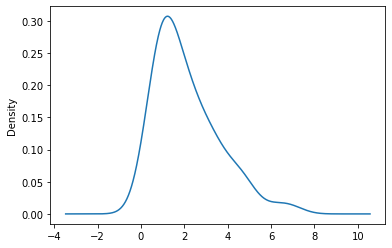

In [9]:
gamma_series.plot.kde()

#### Test for normality

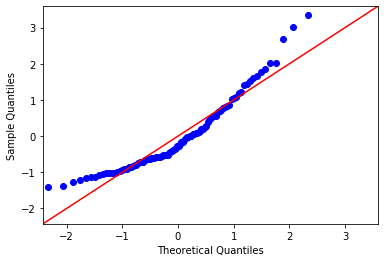

In [10]:
fig = qqplot(gamma_series, fit=True, line='45')
plt.show()

In [11]:
st.shapiro_wilks_(gamma_series)

Statistics=0.912, p=0.000
Sample does not look Gaussian (reject H0)


In [12]:
st.jarque_bera_(gamma_series)

Statistics=22.759, p=0.000, skew=1.087, kurt=3.858
Sample does not look Gaussian (reject H0)


#### Individual control chart

In [13]:
in_control_mean = gamma_series.mean()

In [14]:
MR  = cp.calculate_MR(gamma_series)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [15]:
in_control_mean, in_control_sigma

(2.113958909845155, 1.5248332262835478)

In [16]:
x_ind_params0 = cp.x_ind_params(x = gamma_series, sigma = in_control_sigma, center=in_control_mean)

In [17]:
x_ind_params0 = x_ind_params0.reset_index()

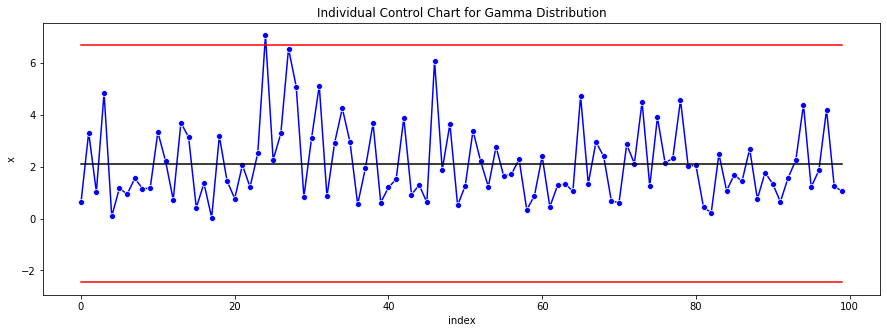

In [18]:
pf.plot_control_chart(
    data=x_ind_params0,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Gamma Distribution',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

In [19]:
(x_ind_params0['obs'] > x_ind_params0['UCL']).sum() / len(x_ind_params0['obs']) + \
(x_ind_params0['obs'] < x_ind_params0['LCL']).sum() / len(x_ind_params0['obs'])

0.01

#### Transform gamma dist

In [20]:
# Test boxcox
from scipy.stats import boxcox
from scipy.special import inv_boxcox

boxcox(gamma_series)[1]

0.3636395382409966

In [21]:
# pt = PowerTransformer(method='yeo-johnson', standardize=False, copy=True)
# pt = PowerTransformer(method='box-cox', standardize=False, copy=True)
pt = g.Gaussianize()

In [22]:
# Remove skew
# gamma_series_transformed = gamma_series - gamma_series.median()

In [23]:
pt_fitted = pt.fit(gamma_series.values.reshape(-1, 1))

In [24]:
gamma_series_transformed = pd.Series(pt_fitted.transform(gamma_series.values.reshape(-1, 1)).flatten())

In [25]:
# lambda_bc = pt_fitted.lambdas_
lambda_bc = pt_fitted.coefs_

In [26]:
# (mu, sigma, delta) for lambert
lambda_bc

[(2.073246262432118, 1.3326995735112128, 0.065334)]

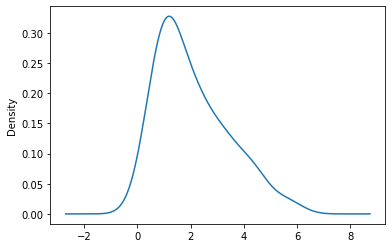

In [27]:
gamma_series_transformed.plot.kde()

#### Test for normality

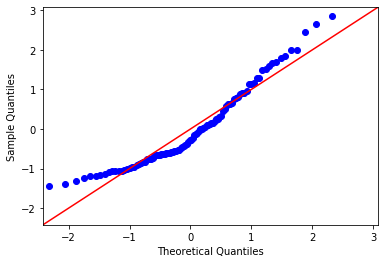

In [28]:
fig = qqplot(gamma_series_transformed, fit=True, line='45')
plt.show()

In [29]:
st.shapiro_wilks_(gamma_series_transformed)

Statistics=0.926, p=0.000
Sample does not look Gaussian (reject H0)


In [30]:
st.jarque_bera_(gamma_series_transformed)

Statistics=11.757, p=0.003, skew=0.839, kurt=2.941
Sample does not look Gaussian (reject H0)


#### Individual control chart (transformed)

In [31]:
in_control_mean = gamma_series_transformed.mean()

In [32]:
MR  = cp.calculate_MR(gamma_series_transformed)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [33]:
# in_control_sigma = gamma_series_transformed.std()

In [34]:
in_control_mean, in_control_sigma

(2.0732465509223683, 1.4086786194973868)

In [35]:
x_ind_params = cp.x_ind_params(x = gamma_series_transformed, sigma = in_control_sigma, center=in_control_mean)

In [36]:
x_ind_params = x_ind_params.reset_index()

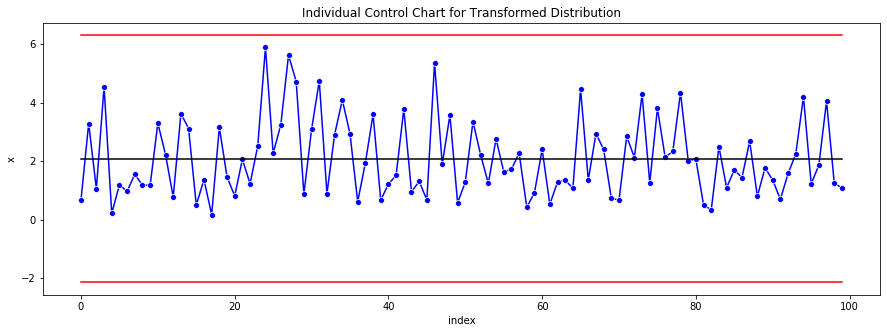

In [37]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Transformed Distribution',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

In [38]:
(x_ind_params['obs'] > x_ind_params['UCL']).sum() / len(x_ind_params['obs']) + \
(x_ind_params['obs'] < x_ind_params['LCL']).sum() / len(x_ind_params['obs'])

0.0

#### Back transform to original

In [39]:
x_ind_params2 = x_ind_params.copy()

In [40]:
x_ind_params2['obs'] = pt_fitted.inverse_transform(x_ind_params2['obs'].values.reshape(-1, 1))
x_ind_params2['UCL'] = pt_fitted.inverse_transform(x_ind_params2['UCL'].values.reshape(-1, 1))
x_ind_params2['Center'] = pt_fitted.inverse_transform(x_ind_params2['Center'].values.reshape(-1, 1))
x_ind_params2['LCL'] = pt_fitted.inverse_transform(x_ind_params2['LCL'].values.reshape(-1, 1))

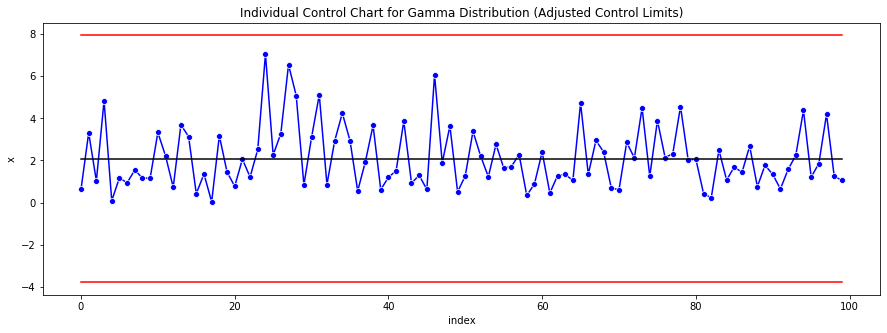

In [41]:
pf.plot_control_chart(
    data=x_ind_params2,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Gamma Distribution (Adjusted Control Limits)',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

In [42]:
(x_ind_params2['obs'] > x_ind_params2['UCL']).sum() / len(x_ind_params2['obs']) + \
(x_ind_params2['obs'] < x_ind_params2['LCL']).sum() / len(x_ind_params2['obs'])

0.0

#### non-parametric method (sample quantiles)

In [43]:
alpha = (1- 0.997)/2

x_ind_params_q = x_ind_params0.copy()
x_ind_params_q['UCL'] = gamma_series.quantile(q=1-alpha)
x_ind_params_q['Center'] = gamma_series.quantile(q=0.5)
x_ind_params_q['LCL'] = gamma_series.quantile(q=alpha)

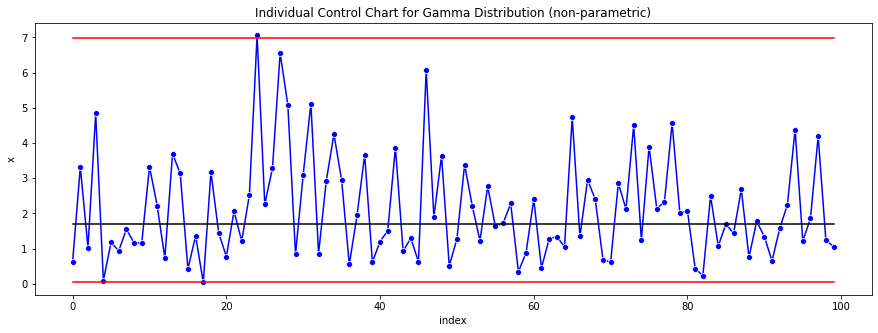

In [44]:
pf.plot_control_chart(
    data=x_ind_params_q,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Gamma Distribution (non-parametric)',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

In [45]:
(x_ind_params_q['obs'] > x_ind_params_q['UCL']).sum() / len(x_ind_params_q['obs']) + \
(x_ind_params_q['obs'] < x_ind_params_q['LCL']).sum() / len(x_ind_params_q['obs'])

0.02

#### non-parametric method (dist quantiles)

In [46]:
x_ind_params_qd = x_ind_params0.copy()
x_ind_params_qd['UCL'] = gamma.ppf(1-alpha, a)
x_ind_params_qd['Center'] = gamma.ppf(0.5, a)
x_ind_params_qd['LCL'] = gamma.ppf(alpha, a)

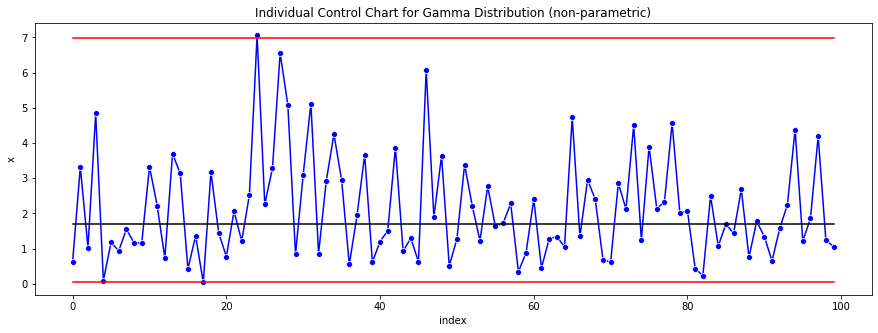

In [47]:
pf.plot_control_chart(
    data=x_ind_params_q,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Gamma Distribution (non-parametric)',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

In [48]:
(x_ind_params_qd['obs'] > x_ind_params_qd['UCL']).sum() / len(x_ind_params_qd['obs']) + \
(x_ind_params_qd['obs'] < x_ind_params_qd['LCL']).sum() / len(x_ind_params_qd['obs'])

0.01